# Object detection model - KITTI og

> Object Detection Model


- skip_showdoc: true
- skip_exec: true

## KITTI

### Trial 1

In [ ]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

# Create a histogram plot
output_notebook()

Loading BokehJS ...

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import Kitti, VisionDataset
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:
import cv2

In [ ]:
class Kitti_v2(Kitti):
    def __init__(self, *args, **kwargs):
        super(Kitti_v2, self).__init__(*args, **kwargs)

In [ ]:
path = './Data'
batch_size = 16

# Define transforms
# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((375, 1242)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [ ]:
# Load KITTI train dataset
train_dataset = Kitti_v2(root=path, train='true', download=True, transform=transform)

# Load KITTI test dataset
test_dataset = Kitti_v2(root=path, train='false', download=True, transform=transform)

In [ ]:
# Create DataLoader for train dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: tuple(zip(*batch)), num_workers = 8)

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: tuple(zip(*batch)), num_workers = 8)

In [ ]:
train_dataset

Dataset Kitti_v2
    Number of datapoints: 7481
    Root location: ./Data
    StandardTransform
Transform: Compose(
               Resize(size=(375, 1242), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
len(train_dataset)

7481

In [ ]:
image, targets = train_dataset[2]
type(targets)

list

In [ ]:
image.shape

torch.Size([3, 375, 1242])

In [ ]:
car_types = ['Car', 'Van', 'DontCare', 'Cyclist', 'Pedestrian', 'Truck', 'Tram', 'Misc', 'Person_sitting']

In [ ]:
car_types = []
for image, targets in tqdm(train_dataset):
    for target in targets:
        if target['type'] not in car_types:
            car_types.append(target['type'])    

print(f'{car_types}')

100%|███████████████████████████████████████████████████████████████████████████████| 7481/7481 [01:47<00:00, 69.82it/s]

['Car', 'Van', 'DontCare', 'Cyclist', 'Pedestrian', 'Truck', 'Tram', 'Misc', 'Person_sitting']


In [ ]:
max_len = 0
target_items = []

for image, targets in tqdm(train_dataset):
    target_items.append(len(targets))
    if len(targets) > max_len:
        max_len = len(targets)

print(f'{max_len}')


100%|███████████████████████████████████████████████████████████████████████████████| 7481/7481 [01:27<00:00, 85.34it/s]

24


In [ ]:
p = figure(title="Histogram of target_items", x_axis_label="Value", y_axis_label="Frequency")
hist, edges = np.histogram(target_items, bins=20)
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="white")
show(p)

In [ ]:
import matplotlib.pyplot as plt

def cv2_show(image_np, label):
    image_cv2 = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

    for i_object in label:
        # Draw the bounding box
        bbox = i_object['bbox']
        cv2.rectangle(image_cv2, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
    
        # Display the label
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image_cv2, i_object['type'], (int(bbox[0]), int(bbox[1]) - 10), font, 0.5, (0, 255, 0), 2, cv2.LINE_AA)

    # Convert the image back to RGB format for display with Matplotlib
    image_rgb = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
    return image_rgb

    
def show_image(kitti_dataset):
    # Access an image and its label from the dataset
    image, label = kitti_dataset
    
    # Convert the image tensor to a NumPy array
    image_np = image.numpy().transpose((1, 2, 0))
    image_rgb = cv2_show(image_np, label)
    # Display the image using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Define a function to display images
def show_images(images, labels, **kwargs):
    nrows = int(math.sqrt(len(images)))
    ncols = int(np.floor(len(images)/nrows))
        
    fig, axes = plt.subplots(nrows, ncols, **kwargs)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    # Display the image using Matplotlib
    for ax, image, label in zip(axes.flat, images, labels):
        # Convert image to numpy array and adjust pixel values
        image_np = image.numpy().transpose((1, 2, 0))
        image_rgb = cv2_show(image_np, label)
        
        # Display image
        ax.imshow(image_rgb)
        ax.axis('off')

    for ax in axes.flat[len(images):]:
        ax.axis('off')
    plt.show()

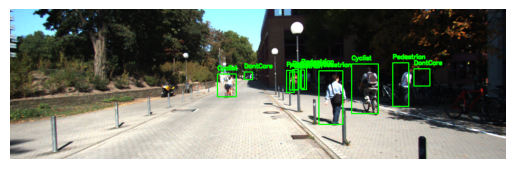

In [ ]:
show_image(train_dataset[18])

#### Iter

In [ ]:
# Get a batch of images and labels from the data loader
examples = iter(train_loader)
images, labels = next(examples)


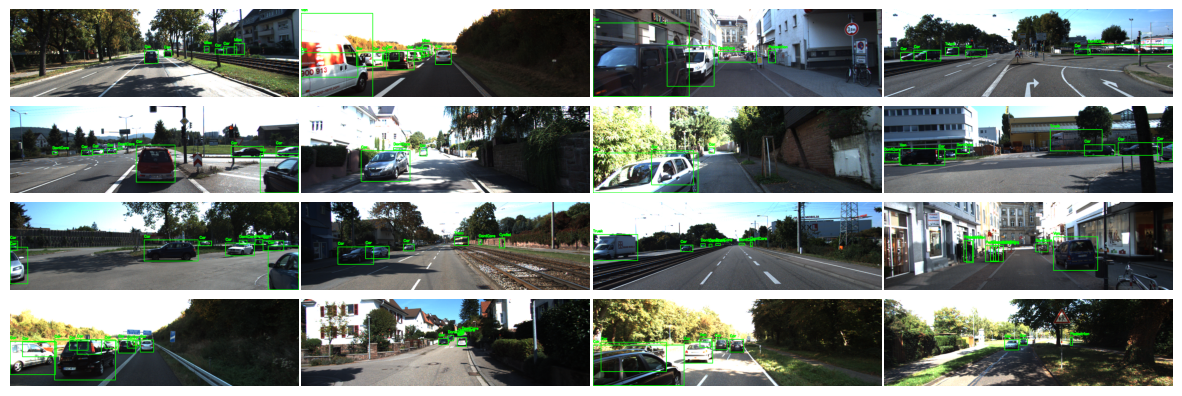

In [ ]:
show_images(images, labels, figsize=(15, 5))

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [ ]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

from torchvision.transforms import v2
from torchvision.io import read_image

torch.manual_seed(1)

# If you're trying to run that on collab, you can download the assets and the
# helpers from https://github.com/pytorch/vision/tree/main/gallery/
img = read_image(str(Path('Data') / 'astronaut.jpg'))

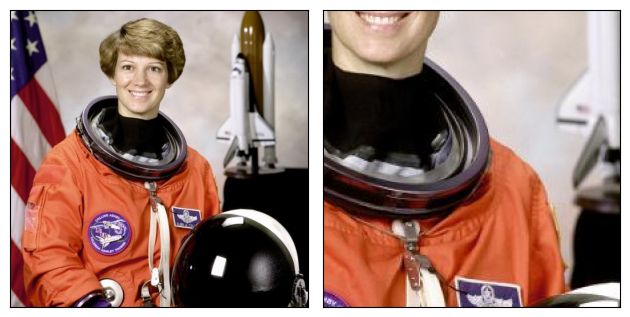

In [ ]:
transform = v2.RandomCrop(size=(224, 224))
out = transform(img)

plot([img, out])

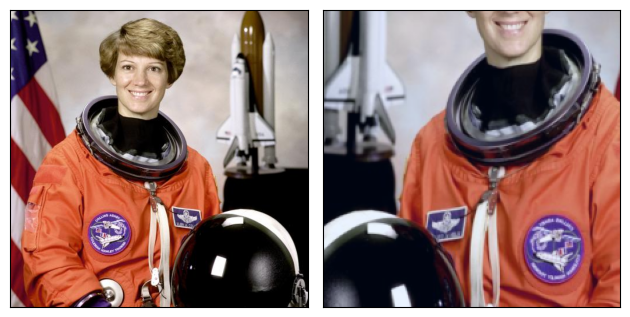

In [ ]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
out = transforms(img)

plot([img, out])

<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>


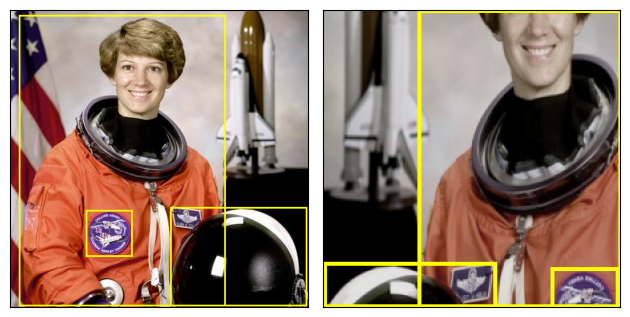

In [ ]:
from torchvision import tv_tensors  # we'll describe this a bit later, bare with us

boxes = tv_tensors.BoundingBoxes(
    [
        [15, 10, 370, 510],
        [275, 340, 510, 510],
        [130, 345, 210, 425]
    ],
    format="XYXY", canvas_size=img.shape[-2:])

transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomPhotometricDistort(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
])
out_img, out_boxes = transforms(img, boxes)
print(type(boxes), type(out_boxes))

plot([(img, boxes), (out_img, out_boxes)])